<a href="https://colab.research.google.com/github/anujsaxena/AIML/blob/main/AIML_Lab_7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM**

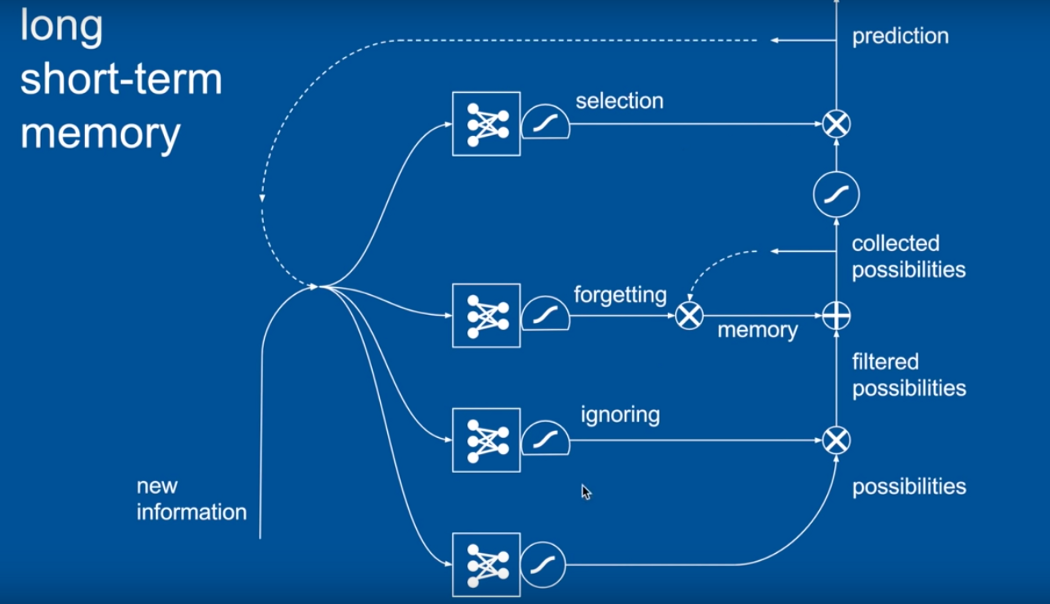

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D


In [ ]:
df_train = pd.read_csv('train.tsv', sep='\t')
print('train set: {0}'.format(df_train.shape))
df_train.head(10)

train set: (156054, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,156060,8544,chortles,2
1,156059,8544,avuncular,2
2,156058,8544,avuncular chortles,3
3,156057,8544,forced avuncular chortles,1
4,156056,8544,Hearst 's,2
5,156055,8544,Hearst 's forced avuncular chortles,2
6,156054,8544,beneath Hearst 's forced avuncular chortles,2
7,156053,8544,sadness and,1
8,156052,8544,sadness and obsession,1
9,156051,8544,the sadness and obsession,2


ASCII characters are ultimately interpreted by the computer as hexadecimal. In consequence, to a computer, ‘A’ is not the same as ‘a’. Therefore, we’ll want to change all characters to lowercase. Since we’re going to be splitting the sentences up into individual words based off of white spaces, a word with a period right after it is not equivalent to one without a period following it (happy. != happy). In addition, contractions are going to be interpreted differently than the original which will have repercussions for the model (I’m != I am). Thus, we replace all occurrences using the proceeding function.

In [ ]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [ ]:
X_train = df_train['Phrase'].apply(lambda p: clean_text(p))

In [ ]:
print(X_train)

0                                                  chortles
1                                                 avuncular
2                                        avuncular chortles
3                                 forced avuncular chortles
4                                                 hearst is
                                ...                        
156049                                               series
156050                                                    a
156051                                             a series
156052    a series of escapades demonstrating the adage ...
156053    a series of escapades demonstrating the adage ...
Name: Phrase, Length: 156054, dtype: object


In [ ]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))

max phrase len: 53


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

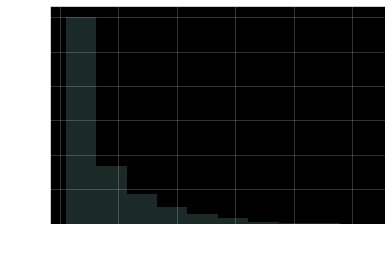

In [ ]:
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [ ]:
y_train = df_train['Sentiment']
print(y_train)

0         2
1         2
2         3
3         1
4         2
         ..
156049    2
156050    2
156051    2
156052    2
156053    1
Name: Sentiment, Length: 156054, dtype: int64


Computers don’t understand words, let alone sentences, therefore, we use the tokenizer to parse the phrases. In specifying num_words, only the most common num_words-1 words will be kept. We use a filter to remove special characters. By default, all punctuation is removed, turning the text into a space separated sequence of words. The tokens are then vectorized. By vectorized we mean that they are mapped to integers. 0 is a reserved index that won't be assigned to any word.

pad_sequence is used to ensure that all the phrase are the same length. Sequences that are shorter than maxlen are padded with value (0 by default) at the end.

Whenever we’re working with categorical data, we don’t want to leave it as integers because the model will interpreted the samples with a higher number as having more significance. to_categorical is quick and dirty way of encoding the data.

In [ ]:
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)
y_train = to_categorical(y_train)

In [ ]:
print(X_train)

0                                                  chortles
1                                                 avuncular
2                                        avuncular chortles
3                                 forced avuncular chortles
4                                                 hearst is
                                ...                        
156049                                               series
156050                                                    a
156051                                             a series
156052    a series of escapades demonstrating the adage ...
156053    a series of escapades demonstrating the adage ...
Name: Phrase, Length: 156054, dtype: object


In [ ]:
print(y_train)

0         2
1         2
2         3
3         1
4         2
         ..
156049    2
156050    2
156051    2
156052    2
156053    1
Name: Sentiment, Length: 156054, dtype: int64


In [ ]:
#define hyper parameters

batch_size = 512
epochs = 8

#build the model

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 256, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation = 'softmax'))
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

Dropout is used to avoid overfitting

In [14]:
#validate the data
history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 8,
    batch_size = 512
)

Epoch 1/8
275/275 [==============================] - 780s 3s/step - loss: 1.0637 - accuracy: 0.5737 - val_loss: 0.9068 - val_accuracy: 0.6445
Epoch 2/8
275/275 [==============================] - 761s 3s/step - loss: 0.8577 - accuracy: 0.6552 - val_loss: 0.8856 - val_accuracy: 0.6524
Epoch 3/8
275/275 [==============================] - 749s 3s/step - loss: 0.8064 - accuracy: 0.6729 - val_loss: 0.8925 - val_accuracy: 0.6486
Epoch 4/8
275/275 [==============================] - 741s 3s/step - loss: 0.7726 - accuracy: 0.6855 - val_loss: 0.9097 - val_accuracy: 0.6558
Epoch 5/8
275/275 [==============================] - 739s 3s/step - loss: 0.7452 - accuracy: 0.6955 - val_loss: 0.9144 - val_accuracy: 0.6553
Epoch 6/8
275/275 [==============================] - 735s 3s/step - loss: 0.7227 - accuracy: 0.7030 - val_loss: 0.9365 - val_accuracy: 0.6552
Epoch 7/8
275/275 [==============================] - 734s 3s/step - loss: 0.7039 - accuracy: 0.7104 - val_loss: 0.9410 - val_accuracy: 0.6538
Epoch 

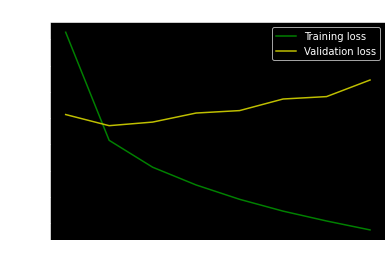

In [15]:
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

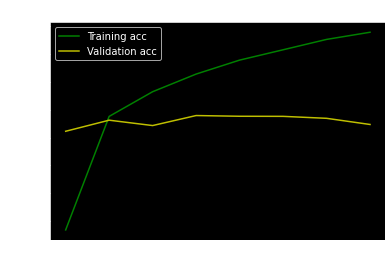

In [16]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Long Short Term Memory Network (LSTM)**

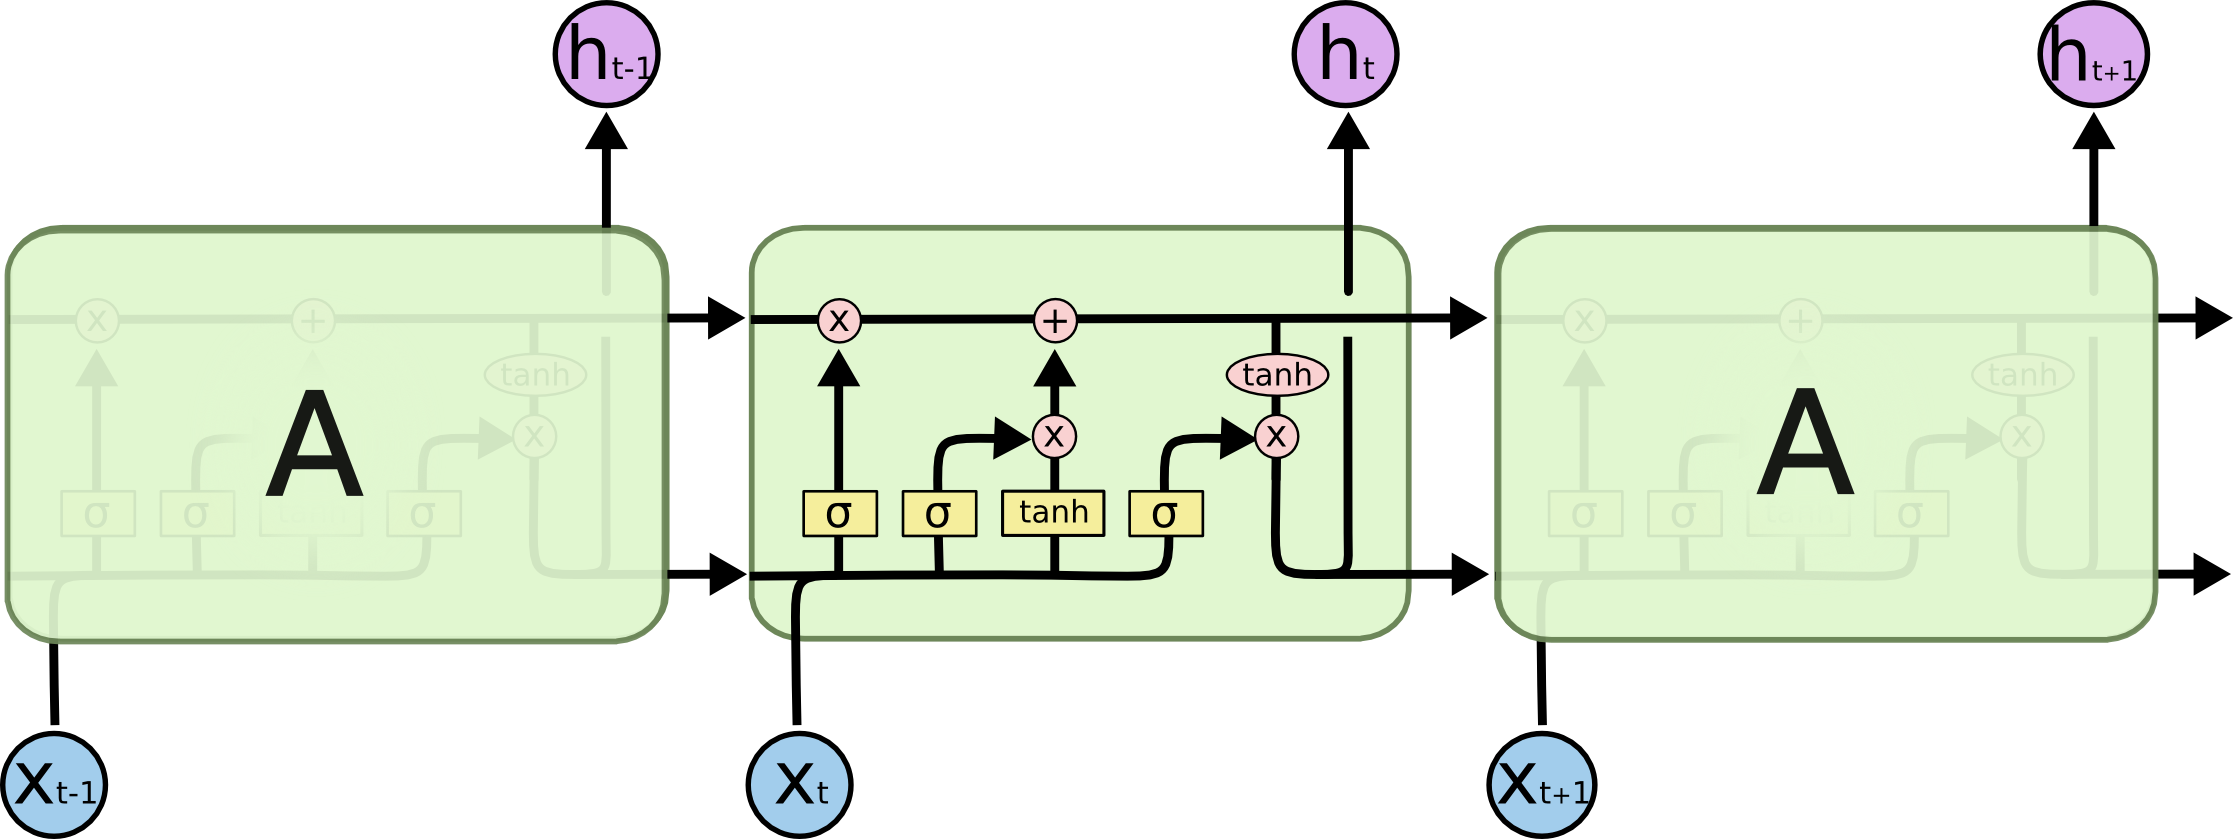
The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.

As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

Instead of neurons, LSTM networks have memory blocks that are connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

1. Forget Gate: conditionally decides what information to throw away from the block.
2. Input Gate: conditionally decides which values from the input to update the memory state.
3. Output Gate: conditionally decides what to output based on input and the memory of the block.


https://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
# **LSTM Network for Regression**

In [17]:
import numpy as np
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed
np.random.seed(2021)

In [18]:
#load dataset
df = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = df.values
dataset = dataset.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [19]:
print(dataset)

[[112.]
 [118.]
 [132.]
 [129.]
 [121.]
 [135.]
 [148.]
 [148.]
 [136.]
 [119.]
 [104.]
 [118.]
 [115.]
 [126.]
 [141.]
 [135.]
 [125.]
 [149.]
 [170.]
 [170.]
 [158.]
 [133.]
 [114.]
 [140.]
 [145.]
 [150.]
 [178.]
 [163.]
 [172.]
 [178.]
 [199.]
 [199.]
 [184.]
 [162.]
 [146.]
 [166.]
 [171.]
 [180.]
 [193.]
 [181.]
 [183.]
 [218.]
 [230.]
 [242.]
 [209.]
 [191.]
 [172.]
 [194.]
 [196.]
 [196.]
 [236.]
 [235.]
 [229.]
 [243.]
 [264.]
 [272.]
 [237.]
 [211.]
 [180.]
 [201.]
 [204.]
 [188.]
 [235.]
 [227.]
 [234.]
 [264.]
 [302.]
 [293.]
 [259.]
 [229.]
 [203.]
 [229.]
 [242.]
 [233.]
 [267.]
 [269.]
 [270.]
 [315.]
 [364.]
 [347.]
 [312.]
 [274.]
 [237.]
 [278.]
 [284.]
 [277.]
 [317.]
 [313.]
 [318.]
 [374.]
 [413.]
 [405.]
 [355.]
 [306.]
 [271.]
 [306.]
 [315.]
 [301.]
 [356.]
 [348.]
 [355.]
 [422.]
 [465.]
 [467.]
 [404.]
 [347.]
 [305.]
 [336.]
 [340.]
 [318.]
 [362.]
 [348.]
 [363.]
 [435.]
 [491.]
 [505.]
 [404.]
 [359.]
 [310.]
 [337.]
 [360.]
 [342.]
 [406.]
 [396.]
 [420.]


In [20]:
#normalize dataset
scaler = MinMaxScaler(feature_range=(0,1))   #create an object for scaling the data between 0 and 1
dataset = scaler.fit_transform(dataset)  #transform the dataset
print(dataset)

[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]
 [0.08494207]
 [0.08494207]
 [0.06177607]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123553]
 [0.04247104]
 [0.07142857]
 [0.05984557]
 [0.04054055]
 [0.08687258]
 [0.12741312]
 [0.12741312]
 [0.10424709]
 [0.05598456]
 [0.01930502]
 [0.06949806]
 [0.07915059]
 [0.08880308]
 [0.14285713]
 [0.11389962]
 [0.13127413]
 [0.14285713]
 [0.18339768]
 [0.18339768]
 [0.15444016]
 [0.11196911]
 [0.08108109]
 [0.1196911 ]
 [0.12934363]
 [0.14671814]
 [0.17181468]
 [0.14864865]
 [0.15250966]
 [0.22007722]
 [0.24324325]
 [0.26640925]
 [0.2027027 ]
 [0.16795367]
 [0.13127413]
 [0.17374519]
 [0.17760617]
 [0.17760617]
 [0.25482625]
 [0.25289574]
 [0.24131274]
 [0.26833975]
 [0.3088803 ]
 [0.32432434]
 [0.25675675]
 [0.20656371]
 [0.14671814]
 [0.18725869]
 [0.19305018]
 [0.16216215]
 [0.25289574]
 [0.23745173]
 [0.25096524]
 [0.3088803 ]
 [0.38223937]
 [0.36486486]
 [0.2992278 ]
 [0.24131274]
 [0.1911197 ]
 [0.24

After we model our data and estimate the skill of our model on the training dataset, we need to get an idea of the skill of the model on new unseen data. For a normal classification or regression problem, we would do this using cross validation.

With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [21]:
#split the data
train_size=int(len(dataset)*.67)
test_size= len(dataset)-train_size
train, test =dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train))
print(len(test))

96
48


The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

In [22]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [23]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [24]:
#reshape

trainX= np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1]))
testX= np.reshape(testX, (testX.shape[0],1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(94, 1, 1)
(46, 1, 1)


The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [25]:
#create the model
model = Sequential()
model.add(LSTM(4, input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 2s - loss: 0.0402 - 2s/epoch - 17ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0199 - 135ms/epoch - 1ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0148 - 132ms/epoch - 1ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0134 - 134ms/epoch - 1ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0126 - 156ms/epoch - 2ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0117 - 136ms/epoch - 1ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0109 - 142ms/epoch - 2ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0101 - 136ms/epoch - 1ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0094 - 132ms/epoch - 1ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0085 - 141ms/epoch - 1ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0077 - 130ms/epoch - 1ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0069 - 131ms/epoch - 1ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0061 - 135ms/epoch - 1ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0054 - 141ms/epoch - 2ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0048 - 140ms/epoch - 1ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0042 - 133ms/epoc

In [26]:
#Predict
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#invert prediction
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
#calculate RMSE

trainScore= math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore= math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.91 RMSE
Test Score: 49.14 RMSE


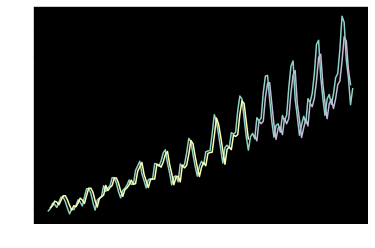

In [27]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()